# Test A/B: tienda en línea

# Contenido

1. [Descripción del análisis](#Descripción-del-análisis)


2. [Vista general de los datos](#Vista-general-de-los-datos)


3. [Corrección de datos](#Corrección-de-datos)
    
    3.1 [Hypotheses](#Hypotheses)
    
    3.2 [Orders](#Orders)
    
    3.3 [Visits](#Visits)
    

4. [Priorización de hipótesis](#Priorización-de-hipótesis)


5. [Análisis del test A/B](#Análisis-del-test-A/B)


6. [Conclusión](#Conclusión)

## Descripción del análisis
<a id="Descripción del análisis"></a>

Junto al equipo de marketing se llevará a cabo este análisis en dos etapas.
Etapa 1 Priorizar hipótesis:
1. Aplicar el framework ICE 
2. Aplicar el framework RICE
3. Mostrar cómo cambia la priorización de hipótesis cuando se utiliza RICE en lugar de ICE.

Etapa 2 Análisis del test A/B: 
1. Se priorizará hipótesis con RICE y ICE
2. El ingreso acumulado por grupo.
3. El tamaño de pedido promedio acumulado por grupo.
4. La diferencia relativa en el tamaño de pedido promedio acumulado para el grupo B en comparación con el grupo A.
5. La tasa de conversión de cada grupo como la relación entre los pedidos y el número de visitas de cada día. 
6. Las tasas de conversión diarias de los dos grupos.
7. Los pedidos por usuario.
8. Los percentiles 95 y 99 para el número de pedidos por usuario, para definir el punto en el cual un punto de datos se convierte en una anomalía.
9. Los precios de los pedidos.
10. Los percentiles 95 y 99 de los precios de los pedidos, para definir el punto en el cual un punto de datos se convierte en una anomalía.
11. La significancia estadística de la diferencia en la conversión entre los grupos utilizando los datos en bruto.
12. La significancia estadística de la diferencia en el tamaño promedio de pedido entre los grupos utilizando los datos en bruto.
13. La significancia estadística de la diferencia en la conversión entre los grupos utilizando los datos filtrados.
14. La significancia estadística de la diferencia en el tamaño promedio de pedido entre los grupos utilizando los datos filtrados. 

Todo esto se llevará a cabo con la finalidad de ayudar a aumentar los ingresos.

## Vista general de los datos
<a id="Vista general de los datos"></a>

In [51]:
# Carga de laas librerías
import pandas as pd
import scipy.stats as stats
import datetime as dt
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from scipy import stats as st

In [2]:
# Carda de los datos
hypotheses = pd.read_csv("/datasets/hypotheses_us.csv", sep=";")
print(hypotheses.info())

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 9 entries, 0 to 8
Data columns (total 5 columns):
 #   Column      Non-Null Count  Dtype 
---  ------      --------------  ----- 
 0   Hypothesis  9 non-null      object
 1   Reach       9 non-null      int64 
 2   Impact      9 non-null      int64 
 3   Confidence  9 non-null      int64 
 4   Effort      9 non-null      int64 
dtypes: int64(4), object(1)
memory usage: 488.0+ bytes
None


In [3]:
# Mostramos el contenido
hypotheses

,Hypothesis,Reach,Impact,Confidence,Effort
0,Add two new channels for attracting traffic. T...,3,10,8,6
1,Launch your own delivery service. This will sh...,2,5,4,10
2,Add product recommendation blocks to the store...,8,3,7,3
3,Change the category structure. This will incre...,8,3,3,8
4,Change the background color on the main page. ...,3,1,1,1
5,Add a customer review page. This will increase...,3,2,2,3
6,Show banners with current offers and sales on ...,5,3,8,3
7,Add a subscription form to all the main pages....,10,7,8,5
8,Launch a promotion that gives users discounts ...,1,9,9,5


No se observan datos ausentes, cuenta con la descripción de 9 hipótesis y su alcance, impacto, confianza y el esfuerzo.

In [4]:
# Carga de datos 
orders = pd.read_csv("/datasets/orders_us.csv")
print(orders.info())

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1197 entries, 0 to 1196
Data columns (total 5 columns):
 #   Column         Non-Null Count  Dtype  
---  ------         --------------  -----  
 0   transactionId  1197 non-null   int64  
 1   visitorId      1197 non-null   int64  
 2   date           1197 non-null   object 
 3   revenue        1197 non-null   float64
 4   group          1197 non-null   object 
dtypes: float64(1), int64(2), object(2)
memory usage: 46.9+ KB
None


In [5]:
# Mostramos el contenido 
orders.head()

,transactionId,visitorId,date,revenue,group
0,3667963787,3312258926,2019-08-15,30.4,B
1,2804400009,3642806036,2019-08-15,15.2,B
2,2961555356,4069496402,2019-08-15,10.2,A
3,3797467345,1196621759,2019-08-15,155.1,B
4,2282983706,2322279887,2019-08-15,40.5,B


A simple vista no se observan datos ausentes y cuenta 1,197 filas. Contiene los datos de las ordenes realizadas por ambos grupos (A y B). 

In [6]:
# carga de datos
visits = pd.read_csv("/datasets/visits_us.csv")
print(visits.info())

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 62 entries, 0 to 61
Data columns (total 3 columns):
 #   Column  Non-Null Count  Dtype 
---  ------  --------------  ----- 
 0   date    62 non-null     object
 1   group   62 non-null     object
 2   visits  62 non-null     int64 
dtypes: int64(1), object(2)
memory usage: 1.6+ KB
None


In [7]:
# Mostramos los datos
visits.head()

,date,group,visits
0,2019-08-01,A,719
1,2019-08-02,A,619
2,2019-08-03,A,507
3,2019-08-04,A,717
4,2019-08-05,A,756


Contiene los datos de las visitas a la página en línea, no se observan datos ausentes y cuenta con 62 filas.

## Corrección de datos
<a id="Corrección de datos"></a>

### Hypotheses
<a id="Hypotheses"></a>

In [8]:
# Convertimos los nombres de las columnas en minúscula
hypotheses.columns = hypotheses.columns.str.lower()
hypotheses.columns

Index(['hypothesis', 'reach', 'impact', 'confidence', 'effort'], dtype='object')

In [9]:
# Buscamos la existencia de datos duplicados
hypotheses.duplicated().sum()

0

Se realizó un cambio en los nombres de las columnas para que fueran todos minúsculas y se verifico la existencia de datos duplicados.

### Orders
<a id="Orders"></a>

In [10]:
# Cambiar los nombres de las columnas para agregar _ a las dos primeras columnas 
orders.rename(columns={"transactionId": "transaction_id", "visitorId": "visitor_id"}, inplace=True)
orders.columns

Index(['transaction_id', 'visitor_id', 'date', 'revenue', 'group'], dtype='object')

In [11]:
# Comprobamos la existencia de duplicados
orders.duplicated().sum()

0

In [12]:
# Cambiamos el tipo de dato
orders["date"] = orders["date"].map(lambda x: dt.datetime.strptime(x, "%Y-%m-%d"))

In [13]:
# Buscamos visitantes que entraron en ambos grupos 
# Filtrar los visitantes por grupo
grup_a_orders = orders[orders["group"] == "A"]
grup_b_orders = orders[orders["group"] == "B"]

# Encontrar visitantes que están en ambos grupos
duplicate_visitors_o = pd.merge(grup_a_orders, grup_b_orders, on="visitor_id", how="inner")

# Mostrar los visitantes duplicados
print(duplicate_visitors_o["visitor_id"].nunique())

58


In [14]:
# Eliminar los visitantes duplicados del dataframe original
df_orders = orders[~orders["visitor_id"].isin(duplicate_visitors_o["visitor_id"])]

# Guardar el dataset limpio
df_orders.to_csv("df_orders.csv", index=False)
df_orders = df_orders.reset_index()
df_orders.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1016 entries, 0 to 1015
Data columns (total 6 columns):
 #   Column          Non-Null Count  Dtype         
---  ------          --------------  -----         
 0   index           1016 non-null   int64         
 1   transaction_id  1016 non-null   int64         
 2   visitor_id      1016 non-null   int64         
 3   date            1016 non-null   datetime64[ns]
 4   revenue         1016 non-null   float64       
 5   group           1016 non-null   object        
dtypes: datetime64[ns](1), float64(1), int64(3), object(1)
memory usage: 47.8+ KB


Se realizó un cambio en los nombres de las columnas, se revisó la existencia de duplicados y se cambió el tipo de dato en la columna date. También se buscó la existencia de usuarios duplicados en ambos grupos (A o B) y se eliminaron.

### Visits
<a id="Visits"></a>

In [15]:
# Comprobamos la existencia de duplicados 
visits.duplicated().sum()

0

In [16]:
# Cambiamos el tipo de dato
visits["date"] = visits["date"].map(lambda x: dt.datetime.strptime(x, "%Y-%m-%d"))

Se comprobó la existencia de datos duplicados y se cambió el tipo de dato de la columna date.  

## Priorización de hipótesis 
<a id="Priorización de hipótesis"></a>

**Aplicar el framework ICE para priorizar hipótesis.**

In [17]:
# Aplicamos la fórmula correspondiente para ICE
hypotheses["ICE"] = (hypotheses["impact"] * hypotheses["confidence"]) / hypotheses["effort"]

print(hypotheses[["hypothesis", "ICE"]].sort_values(by="ICE", ascending=False))

                                          hypothesis        ICE
8  Launch a promotion that gives users discounts ...  16.200000
0  Add two new channels for attracting traffic. T...  13.333333
7  Add a subscription form to all the main pages....  11.200000
6  Show banners with current offers and sales on ...   8.000000
2  Add product recommendation blocks to the store...   7.000000
1  Launch your own delivery service. This will sh...   2.000000
5  Add a customer review page. This will increase...   1.333333
3  Change the category structure. This will incre...   1.125000
4  Change the background color on the main page. ...   1.000000


**Aplicar el framework RICE para priorizar hipótesis**

In [18]:
# Aplicamos la fórmula correspondiente para RICE
hypotheses["RICE"] = (hypotheses["reach"]*hypotheses["impact"]*hypotheses["confidence"])/hypotheses["effort"]

print(hypotheses[["hypothesis", "RICE"]].sort_values(by="RICE", ascending=False))

                                          hypothesis   RICE
7  Add a subscription form to all the main pages....  112.0
2  Add product recommendation blocks to the store...   56.0
0  Add two new channels for attracting traffic. T...   40.0
6  Show banners with current offers and sales on ...   40.0
8  Launch a promotion that gives users discounts ...   16.2
3  Change the category structure. This will incre...    9.0
1  Launch your own delivery service. This will sh...    4.0
5  Add a customer review page. This will increase...    4.0
4  Change the background color on the main page. ...    3.0


AL aplicar la fórmula para obtener el puntaje ICE las hipótesis con un puntaje considerable fueron: 
- Lanzar una promoción que ofrezca descuentos a los usuarios
- Añadir dos nuevos canales para atraer tráfico
- Añadir un formulario de suscripción a todas las paginas principales
Y al aplicar la fórmula para obtener el puntaje RICE las hipótesis con un puntaje considerable fueron:
- Añadir un formulario de suscripción a todas las paginas principales
- Agregar bloques de recomendación de productos a la tienda
- Añadir dos nuevos canales para atraer tráfico

Se puede observar que dos hipótesis coinciden en ambas fórmulas, por lo que podemos decir que las hipótesis en cuestión son lo suficientemente fuertes como para ser priorizadas y exploradas en mayor profundidad.
Por lo cual se escoge la hipótesis que dice "Añadir un formulario de suscripción a todas las paginas principales", ya que esta tiene un alcance de 10, un impacto de 7, confianza de 8 y esfuerzo de 5. 

## Análisis del test A/B
<a id="Análisis del test A/B"></a>

**Ingreso acumulado por grupo**

In [19]:
# Agrupamos por fecha y grupo 
dates_groups = df_orders[["date", "group"]].drop_duplicates()
# Agregamos le número de usuarios a df_orders
orders_aggregated = dates_groups.apply(
    lambda x: df_orders[np.logical_and(df_orders["date"] <= x["date"], df_orders['group'] == x['group'])].agg({
"date" : "max",
"group" : "max",
"transaction_id" : pd.Series.nunique,
"visitor_id" : pd.Series.nunique,
"revenue" : "sum"}), axis=1).sort_values(by=["date","group"])
# Almacenamos grupo fecha y número de pedidos
visitors_aggregated = dates_groups.apply(lambda x: visits[np.logical_and(visits["date"] <= x["date"], visits["group"] == x["group"])]
                                        .agg({"date": "max", "group": "max", "visits": "sum"}), axis=1).sort_values(by=["date", "group"])
# Unimos las variables 
cumulative_data = orders_aggregated.merge(visitors_aggregated, left_on=["date", "group"], right_on=["date", "group"])
cumulative_data.columns = ["date", "group", "orders", "buyers", "revenue", "visits"]
print(cumulative_data.head())

        date group  orders  buyers  revenue  visits
0 2019-08-01     A      23      19   2266.6     719
1 2019-08-01     B      17      17    967.2     713
2 2019-08-02     A      42      36   3734.9    1338
3 2019-08-02     B      40      39   3535.3    1294
4 2019-08-03     A      66      60   5550.1    1845


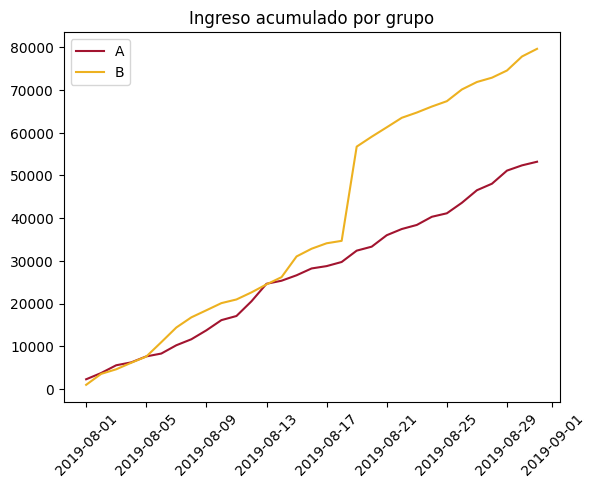

In [20]:
# Separamos los datos por grupo 
cumulative_revenue_A = cumulative_data[cumulative_data["group"] == "A"][["date", "revenue", "orders"]]
cumulative_revenue_B = cumulative_data[cumulative_data["group"] == "B"][["date", "revenue", "orders"]] 
# Gráfica de ingreso acumulado
plt.plot(cumulative_revenue_A["date"], cumulative_revenue_A["revenue"], label="A", color="#A2142F")
plt.plot(cumulative_revenue_B["date"], cumulative_revenue_B["revenue"], label="B", color="#EDB120")

plt.title("Ingreso acumulado por grupo")
plt.xticks(rotation=45)
plt.legend()

Al inicio ambos grupos tienen incrementos durante toda la prueba, en los primeros 5 días los ingresos son similares, pero estos empiezan a cambiar desde el día 5 hasta el día 13, donde el grupo B obtiene mayores ingresos, para el día 13 los ingresos son demasiado similares. Del día 14 en adelante el grupo B aumenta son ingresos más que el grupo A hasta el final de la prueba.

**Tamaño del pedido promedio acumulado por grupo**

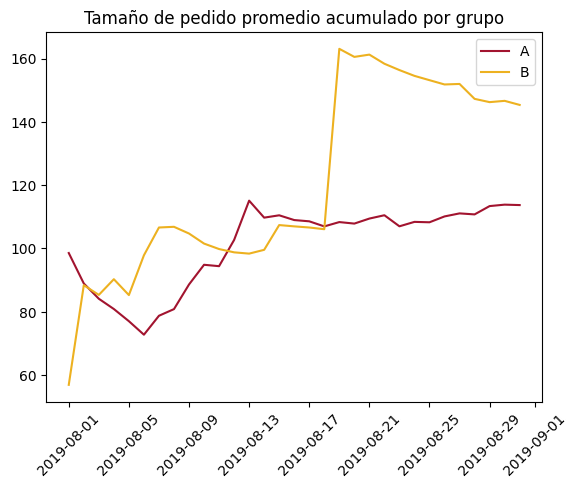

In [21]:
# Obtenemos el tamaño de pedido promedio acumulado
plt.plot(cumulative_revenue_A["date"], cumulative_revenue_A["revenue"]/cumulative_revenue_A["orders"], label="A", color="#A2142F")
plt.plot(cumulative_revenue_B["date"], cumulative_revenue_B["revenue"]/cumulative_revenue_B["orders"], label="B", color="#EDB120")

plt.title("Tamaño de pedido promedio acumulado por grupo")
plt.xticks(rotation=45)
plt.legend()

El tamaño promedio del pedido para el grupo A después del día 5 comienza aumentar hasta aproximadamente el día 13, al finalizar este se estabiliza y tiene un mínimo incremento. Para el grupo B la gráfica muestra incrementos considerables durante toda la prueba en especial para el día 18 o 19 aproximadamente. 

**Diferencia relativa en el tamaño de pedido promedio acumulado para el grupo B en comparación con el grupo A**

In [22]:
# Unimos los ingresos acumulados de los dos grupos
cumulative_revenue = cumulative_revenue_A.merge(cumulative_revenue_B, left_on="date", right_on="date", how="left", suffixes=["A", "B"])
cumulative_revenue.head()

,date,revenueA,ordersA,revenueB,ordersB
0,2019-08-01,2266.6,23,967.2,17
1,2019-08-02,3734.9,42,3535.3,40
2,2019-08-03,5550.1,66,4606.9,54
3,2019-08-04,6225.6,77,6138.5,68
4,2019-08-05,7623.6,99,7587.8,89


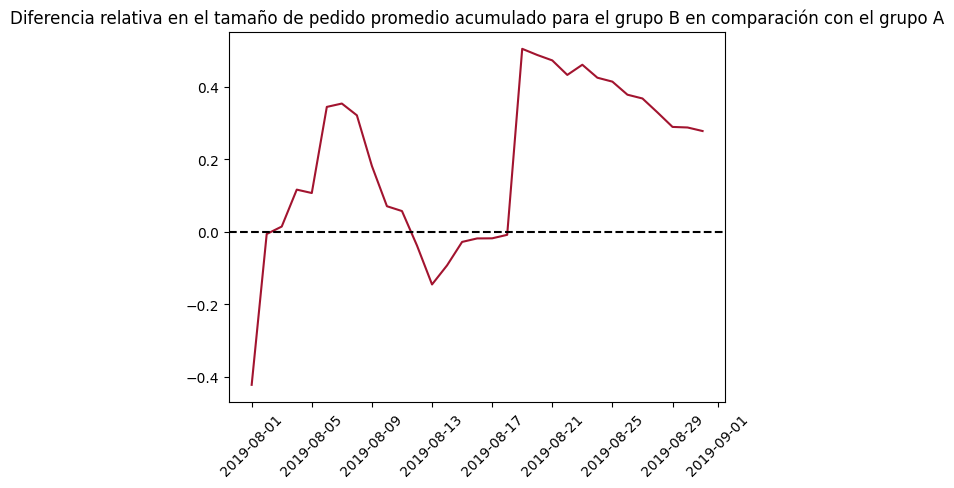

In [23]:
# Gráfica de la diferencia relativa
plt.plot(cumulative_revenue["date"], (cumulative_revenue["revenueB"]/cumulative_revenue["ordersB"])/ (cumulative_revenue["revenueA"]/cumulative_revenue["ordersA"])-1, color="#A2142F")

plt.title("Diferencia relativa en el tamaño de pedido promedio acumulado para el grupo B en comparación con el grupo A")
plt.xticks(rotation=45)

plt.axhline(y=0, color='black', linestyle='--')

A lo largo del tiempo se encuentran con aumentos y disminuciones bastante notales, lo que significa que se encuentran algunos valores atípicos o pedidos que fueron más grandes en consideración con el promedio.

**Tasa de conversión de cada grupo como la relación entre los pedidos y el número de visitas de cada día.**

In [24]:
# Agregamos una columna para la tasa de convesión 
cumulative_data["conversion"] = cumulative_data["orders"]/cumulative_data["visits"]
cumulative_data_A = cumulative_data[cumulative_data["group"] == "A"]
cumulative_data_B = cumulative_data[cumulative_data["group"] == "B"]
print(cumulative_data_A.head())
print(cumulative_data_B.head())

        date group  orders  buyers  revenue  visits  conversion
0 2019-08-01     A      23      19   2266.6     719    0.031989
2 2019-08-02     A      42      36   3734.9    1338    0.031390
4 2019-08-03     A      66      60   5550.1    1845    0.035772
6 2019-08-04     A      77      71   6225.6    2562    0.030055
8 2019-08-05     A      99      92   7623.6    3318    0.029837
        date group  orders  buyers  revenue  visits  conversion
1 2019-08-01     B      17      17    967.2     713    0.023843
3 2019-08-02     B      40      39   3535.3    1294    0.030912
5 2019-08-03     B      54      53   4606.9    1803    0.029950
7 2019-08-04     B      68      66   6138.5    2573    0.026428
9 2019-08-05     B      89      87   7587.8    3280    0.027134


**Tasas de conversión diarias de los dos grupos**

(18109.0, 18139.0, 0.0, 0.05)

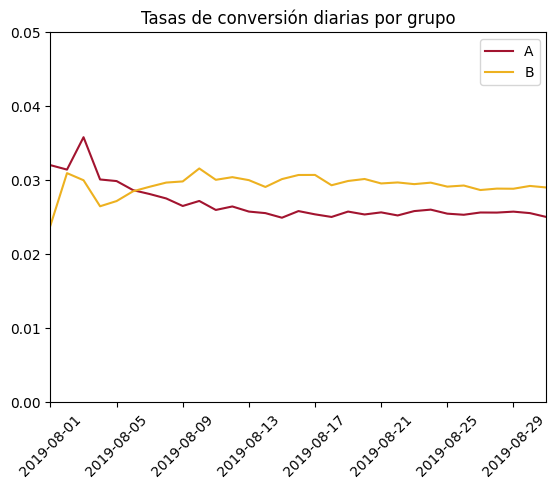

In [25]:
# Gráfica de la tasa de coverisión diaria
plt.plot(cumulative_data_A["date"], cumulative_data_A["conversion"], label="A", color="#A2142F")
plt.plot(cumulative_data_B["date"], cumulative_data_B["conversion"], label="B", color="#EDB120")
plt.legend()

plt.title("Tasas de conversión diarias por grupo")
plt.xticks(rotation=45)
plt.axis([pd.to_datetime("2019-08-01"), pd.to_datetime("2019-08-31"), 0, 0.05])

Ambos grupos al inicio muestran un aumento, después del día 7 estos comienzan a estabilizarse, aunque el grupo B si tuvo un aumento en comparación del grupo A.

**Gráfico de dispersión del número de pedidos por usuario**

In [26]:
# Obtenemos las ordenes hechas por los usuarios
# Eliminamos las filas del grupo, día e ingresos
# Agrupamos por usuario y obtenemos valores únicos 
orders_by_users = (
    df_orders.drop(["group", "revenue", "date"], axis=1)
    .groupby("visitor_id", as_index=False)
    .agg({"transaction_id": pd.Series.nunique})
)
orders_by_users.columns = ["user_id", "orders"]
print(orders_by_users.sort_values(by="orders", ascending=False).head())

        user_id  orders
908  3967698036       3
55    249864742       3
478  2108163459       3
687  2988190573       3
890  3908431265       3


Text(0.5, 1.0, 'Pedidos por usuario')

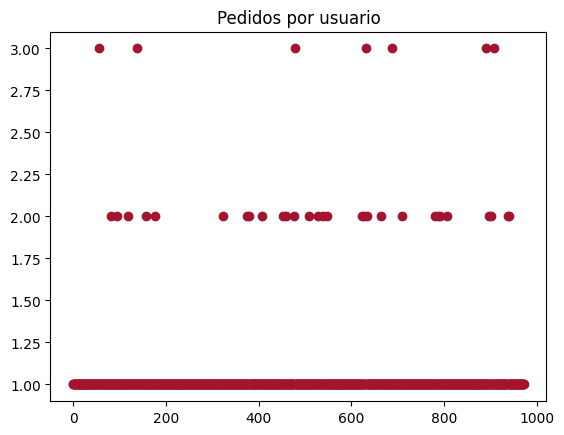

In [27]:
# Gráfico de dispersión 
x_values = pd.Series(range(0,len(orders_by_users)))
plt.scatter(x_values, orders_by_users["orders"], color="#A2142F")

plt.title("Pedidos por usuario")

La concentración de la mayoría de los datos se encuentra en el 1, lo que nos dice que la mayoría de las veces que se realizó un pedido solo fue de 1, empieza a disminuir los usuarios que solo hicieron un pedido y para los que hicieron 3 pedidos el numero disminuye aún más.

**Percentiles 95 y 99 para el número de pedidos por usuario y el punto en el cual un punto de datos se convierte en una anomalía.**

In [28]:
# Calculamos los percentiles 95 y 99
print(np.percentile(orders_by_users["orders"], [95, 99]))

[1. 2.]


Lo más notable que podemos observar es que no más del 1% de los pedidiso realizados por los usuarios es de 2 pedidos por usuario. El 95% de los usuarios solo realiza un pedido o menos. Los usuarios con más de dos pedidos se pueden considerar anomalías.

**Gráfico de dispersión de los precios de los pedidos**

In [47]:
# Obtenemos los precios de los pedidos 
print(df_orders.sort_values(by="revenue",ascending=False).head())

      index  transaction_id  visitor_id       date  revenue group
365     425       590470918  1920142716 2019-08-19  19920.4     B
1015   1196      3936777065  2108080724 2019-08-15   3120.1     B
971    1136       666610489  1307669133 2019-08-13   1425.8     A
632     744      3668308183   888512513 2019-08-27   1335.6     B
631     743      3603576309  4133034833 2019-08-09   1050.0     A


Text(0.5, 1.0, 'Precio de los pedidos')

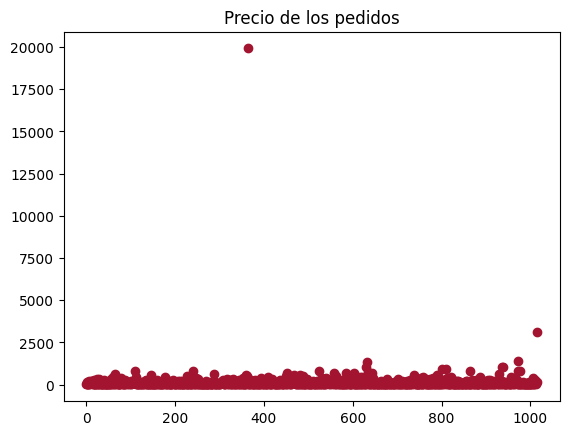

In [30]:
# Gráfico de dispersión de los precios de los pedidos
x_values = pd.Series(range(0,len(df_orders["revenue"])))
plt.scatter(x_values, df_orders["revenue"], color="#A2142F")
plt.title("Precio de los pedidos")

Como se puede observar en el grafico la mayoría de los pedidos no pasa de los 2,500 dólares, y existe un solo pedido que llega casi a los 20,000 dólares y otro que llega a los 3,120.1 dólares.

**Percentiles 95 y 99 de los precios de los pedidos y el punto en el cual un punto de datos se convierte en una anomalía.**

In [31]:
# Calculamos los percentiles 95 y 99
print(np.percentile(df_orders["revenue"], [95, 99]))

[414.275 830.3  ]


Podemos decir que solo el 5% de los pedidos cuesta más de 414.275 dólares y la mayoría del costo de los pedidos está por debajo de los 830.3 dólares. los datos se convierten en anomalías cuando superan los 830.3 dólares. 

**Significancia estadística de la diferencia en la conversión entre los grupos utilizando los datos en bruto**

In [42]:
# Buscamos a los usuarios de ambos grupos con al menos un pedido
orders_by_users_A = df_orders[df_orders["group"]=="A"].groupby("visitor_id", as_index=False).agg({"transaction_id": pd.Series.nunique})
orders_by_users_A.columns = ["visitor_id", "orders"] 
orders_by_users_B = df_orders[df_orders["group"]=="B"].groupby("visitor_id", as_index=False).agg({"transaction_id": pd.Series.nunique})
orders_by_users_B.columns = ["visitor_id", "orders"]

sample_A = pd.concat([orders_by_users_A["orders"],pd.Series(0, index=np.arange(visits[visits["group"]=="A"]["visits"].sum() - len(orders_by_users_A["orders"])), name="orders")], axis=0)
sample_B = pd.concat([orders_by_users_B["orders"],pd.Series(0, index=np.arange(visits[visits["group"]=="B"]["visits"].sum() - len(orders_by_users_B["orders"])), name="orders")], axis=0)
print("{0:.3f}".format(stats.mannwhitneyu(sample_A, sample_B)[1]))
print("{0:.3f}".format(sample_B.mean()/sample_A.mean()-1))

0.011
0.160


El valor p de 0.011 no es mayor que 0.05, por lo que rechazamos la hipótesis nula. La diferencia de conversión entre los grupos A y B es de 16%.

**Significancia estadística de la diferencia en el tamaño promedio de pedido entre los grupos utilizando los datos en bruto**

In [43]:
# Buscamos la significancia estadística con .mannwhitneyu
print("{0:.3f}".format(stats.mannwhitneyu(orders[orders["group"]=="A"]["revenue"], df_orders[df_orders["group"]=="B"]["revenue"])[1]))
print("{0:.3f}".format(df_orders[df_orders["group"]=="B"]["revenue"].mean()/df_orders[df_orders["group"]=="A"]["revenue"].mean()-1))

0.888
0.278


El valor p que es de 0.888 es mayor que 0.05. La diferencia en el tamaño promedio de pedido entre los grupos es de 27.8%. 

**Significancia estadística de la diferencia en la conversión entre los grupos utilizando los datos filtrados**

In [44]:
# Eliminamos las anomalías de los datos
# Pedidos que osn mayores que dos
# Gasto mayor a 1000
users_with_many_orders = pd.concat([orders_by_users_A[orders_by_users_A["orders"] > 2]["visitor_id"], orders_by_users_B[orders_by_users_B["orders"] > 2]["visitor_id"]], axis = 0)
users_with_expensive_orders = df_orders[df_orders["revenue"] > 1000]["visitor_id"]
abnormal_users = pd.concat([users_with_many_orders, users_with_many_orders], axis = 0).drop_duplicates().sort_values()
print("Total de usuarios anormales", abnormal_users.count())
print(abnormal_users.head())

Total de usuarios anormales 7
33      249864742
58      611059232
211    2108163459
347    2742574263
310    2988190573
Name: visitor_id, dtype: int64


In [45]:
# Eliminamos los datos de las anomalías
sample_A_filtered = pd.concat([orders_by_users_A[np.logical_not(orders_by_users_A["visitor_id"].isin(abnormal_users))]["orders"],
                               pd.Series(0, index=np.arange(visits[visits["group"]=="A"]["visits"].sum() - len(orders_by_users_A["orders"])),name="orders",),],axis=0)
sample_B_filtered = pd.concat([orders_by_users_B[np.logical_not(orders_by_users_B["visitor_id"].isin(abnormal_users))]["orders"],
                               pd.Series(0, index=np.arange(visits[visits["group"]=="B"]['visits'].sum() - len(orders_by_users_B["orders"])),name="orders",),],axis=0)

print("{0:.3f}".format(stats.mannwhitneyu(sample_A_filtered, sample_B_filtered)[1]))
print("{0:.3f}".format(sample_B_filtered.mean()/sample_A_filtered.mean()-1))

0.008
0.185


El valor p de 0.008 es mucho menor que 0.05, existen diferencias significativas entre las distribuciones de los dos grupos comparados, la diferencia de conversión entre los grupos con los datos filtrados es de 18.4%. En comparación con los datos no filtrados el porcentaje  aumento un 2.5%.

**Significancia estadística de la diferencia en el tamaño promedio de pedido entre los grupos utilizando los datos filtrados**

In [41]:
# Eliminamos los datos con anomalías 
print("{0:.3f}".format(stats.mannwhitneyu(df_orders[np.logical_and(df_orders["group"]=="A",
        np.logical_not(df_orders["visitor_id"].isin(abnormal_users)))]["revenue"],df_orders[np.logical_and(df_orders["group"]=="B",
        np.logical_not(df_orders["visitor_id"].isin(abnormal_users)))]["revenue"])[1]))
print("{0:.3f}".format(df_orders[np.logical_and(df_orders["group"]=="B",
        np.logical_not(df_orders["visitor_id"].isin(abnormal_users)))]["revenue"].mean()/df_orders[np.logical_and(df_orders["group"]=="A",
        np.logical_not(df_orders["visitor_id"].isin(abnormal_users)))]["revenue"].mean()-1))

0.749
0.279


El Valor p de 0.749 es significativamente mayor que 0.05, y la diferencia en el tamaño promedio de pedido con los datos filtrados es de 27.9%, en comparación con los datos no filtrados esta diferencia aumenot un 0.1%.

## Conclusión 
<a id="Conclusión"></a>

Al rechazar la hipótesis nula en el test A/B, podemos concluir que existe evidencia estadística suficiente para decir que existe una diferencia significativa entre las dos variantes (grupo A y grupo B). Se concluye que en la prueba el grupo B es el grupo líder, al rechazar la hipótesis nula que nos dice que existen diferencias significativas entre las distribuciones de los dos grupos comparados, por lo que no podemos decir que no existe tal diferencia. Además, no se puede continuar con la prueba debido a que el tiempo en el que se realizó la prueba es más de tres semanas y que son poco más de 1000 datos.

Es por estos criterios que concluimos que tenemos un grupo líder, y para concluir que el grupo líder es el grupo B tomamos en cuenta en análisis que se llevó a cabo en la prueba, el ingreso acumulado por grupo donde se observa que el grupo B es el que cuenta con un ingreso más elevado que el grupo A y que este sigue creciendo a lo largo de la prueba, también se toma en cuenta el tamaño promedio de pedido acumulado por grupo que aunque la primera mitad de la prueba son similares este tiende a aumentar y por último se toma en cuenta la tasa de conversión que aunque al inicio muestra un pico de ascenso y descenso este aumenta más que el grupo A y se estabiliza. 

Así es como se concluye que el grupo B es el grupo líder.